In [ ]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import json
import time

import folium
import utm

import numpy as np
import pandas as pd
import PIL

import scipy
import scipy.stats
import scipy.signal

from tqdm.auto import tqdm
from IPython.core.display import display, HTML
import ipywidgets as widgets

import matplotlib.pyplot as plt
import plotly.offline as ply
import plotly.graph_objs as plygo
import cufflinks as cf
ply.init_notebook_mode(connected=False)
cf.set_config_file(offline=True, world_readable=False, theme='white')

import torch
import torch.nn as nn
from torch import Tensor
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.transforms


sys.path.insert(0,'../kiranphd')
from hsi.dataset import HSIDataset
import prospect

In [ ]:
trainDatasetPixel = HSIDataset(rasterFile='../data/hyperspectral/20170820_Reflectance_Resampled.tif', 
                               shapeFile='../data/hyperspectral/ground-site-shapefile/20170820_GrassSitesKiran.shp',                               
                               mode='pixel',
                               stage="train"
                              )

(301, 87)


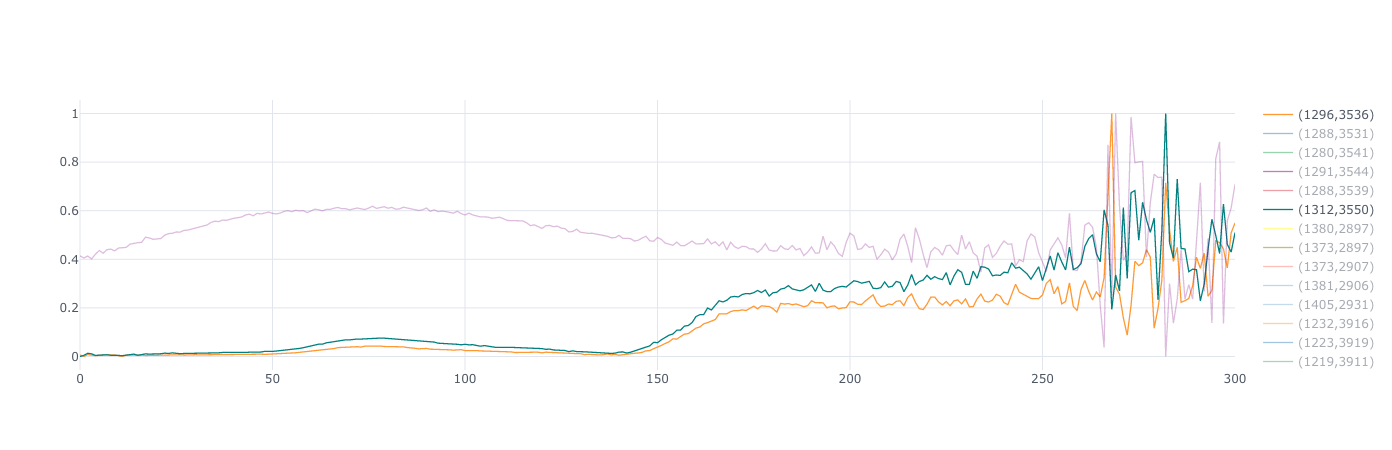

In [74]:
X, Y = 617173.243332,  4875981.89213
latlon = utm.to_latlon(easting=X, northing=Y, northern=True, zone_number=17)
m = folium.Map(location=latlon, detect_retina=True, zoom_start=16)

trainLoaderPixel = torch.utils.data.DataLoader(dataset=trainDatasetPixel, batch_size=1, shuffle=False)
columns=[]
targets=[]
pixels =[]

for i, (pixel, target, row, col) in enumerate(trainLoaderPixel):
    coords = list(zip(row.tolist(), col.tolist()))    
    for i, (r,c) in enumerate(coords):
        r = int(r)
        c = int(c)
        rc = (r,c)        
        columns.append(f"({r},{c})")
        pixels.append(pixel.numpy()[i])

        this = trainDatasetPixel.groundTruth['row,col']==rc
        gt = trainDatasetPixel.groundTruth[this]['Covertype'].tolist()[-1]
        Y = trainDatasetPixel.groundTruth[this]['Xutm'].tolist()[-1]
        X = trainDatasetPixel.groundTruth[this]['Yutm'].tolist()[-1]        
        
        latlon = utm.to_latlon(easting=X, northing=Y, northern=True, zone_number=17)
        folium.Marker(latlon, popup=f"""LatLon: {latlon} <br> Pixel: {rc} <br>""").add_to(m)

        
        #df = pd.DataFrame(pixel.numpy()[i], columns=[rc])
        #html = ply.offline.plot(df.iplot(asFigure=True), include_plotlyjs=False, output_type='div')
        #html = folium.Html(html)
        #popup = folium.Popup(html=html, parse_html=True )
        #folium.Marker(latlon, popup=popup).add_to(m)        

pixels = np.array(pixels).T
print(pixels.shape)
df = pd.DataFrame(pixels, columns=columns)
df.iplot()
        
upperLeft, bottomRight =  trainDatasetPixel.bounds
upperLeft   = utm.to_latlon(easting=upperLeft[0], northing=upperLeft[1], northern=True, zone_number=17)
bottomRight = utm.to_latlon(easting=bottomRight[0], northing=bottomRight[1], northern=True, zone_number=17)

folium.Marker(upperLeft, popup=f'Upper Left').add_to(m)
folium.Marker(bottomRight, popup=f'Bottom Right').add_to(m)

#box = np.zeros((trainDatasetPixel.gdalImage.RasterYSize, trainDatasetPixel.gdalImage.RasterXSize))
box = np.zeros((101,101))
box[0, :] = 1.0
box[100, :] = 1.0
box[:, 0] = 1.0
box[:, 100] = 1.0

folium.raster_layers.ImageOverlay(image=box, bounds=[upperLeft, bottomRight], colormap=lambda x: (1, 0, 0, x)).add_to(m)

# folium.raster_layers.ImageOverlay(name='HyperSpectral UofT', image=trainDatasetPixel.RGB, bounds=[top, bottom], opacity=0.6).add_to(m)    
display(m)

# Mosaic (patches of images instead of pixels)

In [75]:
# cropSize=300
# nCropsPerImage = 20
# _ = trainDataset.createRandomCropParams(cropSize=cropSize, nCropsPerImage=nCropsPerImage)

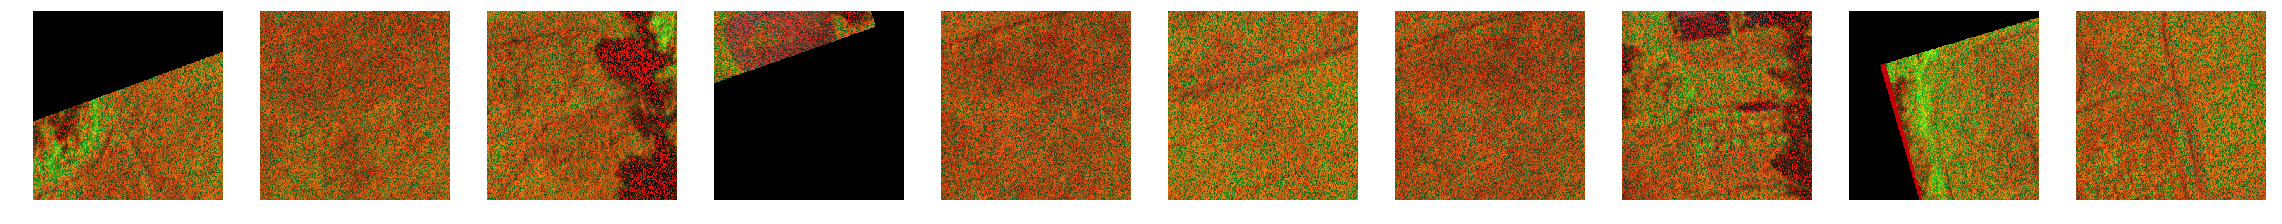

In [76]:
trainDataset = HSIDataset(rasterFile='../data/hyperspectral/20170820_Reflectance_Resampled.tif', 
                          shapeFile='../data/hyperspectral/ground-site-shapefile/20170820_GrassSitesKiran.shp',                               
                          mode='patch')
trainLoader = torch.utils.data.DataLoader(dataset=trainDataset)
cropSize = trainDataset.cropSize

c=0
fig, axs = plt.subplots(1,10, figsize=(40,15))
for i, (inputData, target) in tqdm(enumerate(trainLoader)):
    c = i%10
    #print(inputData.shape)
    #bands 100, 200, and 300 are somewhat close to RGB (ideally it should be an average on the visible RGB intervals)

    #blue = inputData.numpy()[:,100:101,:,:].mean(axis=1, keepdims=True).reshape(cropSize,cropSize)
    blue = inputData.numpy()[:,100,:,:].reshape(cropSize,cropSize)*255
    blue = blue.astype('uint8')
    
    #green = inputData.numpy()[:,200:201,:,:].mean(axis=1, keepdims=True).reshape(cropSize,cropSize)
    green = inputData.numpy()[:,200,:,:].reshape(cropSize,cropSize)*255
    green = green.astype('uint8')

    
    #red = inputData.numpy()[:,300:301,:,:].mean(axis=1, keepdims=True).reshape(cropSize,cropSize)
    red = inputData.numpy()[:,300,:,:].reshape(cropSize,cropSize)*255
    red = red.astype('uint8')
    
    _in = np.dstack([red, green, blue])
    axs[c].imshow(_in, cmap='gist_earth')    
    axs[c].axis('off')
    c+=1
    if i>=9: break
        
plt.show()